## SANJAI R - 2022510011
### AI&DS - 6th SEM
### Applied AI - Assignment 1
### Madras Institute of Technology
### 23.02.2025

## NOTE: 

This Assignment contains 4 CNN models followed by 3 RESNET Variations Models (Transfer Learning)
I have used RTX 4060 with 8GB VRAM Graphics Card. For me the total training time is approximately 20 mins (for all models) on an average of 10 epochs(Excluding Early stoping).

If you are running the notebook it might take hours of training time if you use CPU. So try consider using a GPU powered Machine or use Cloud GPU like Google Colab or Kaggle Notebooks.

I hvae provided the all the saved models. Feel free to use the saved models.

## Pneumonia Detection Using X-Ray Images with CNNs and Transfer Learning

Pneumonia kills! This project is mainly a demonstration of a variety of CNN techniques, though it also shows how applying deep learning can revolutionise healthcare and save lives.

According to the [World Health Organization](https://www.who.int/health-topics/pneumonia#tab=tab_1):

> Pneumonia is a form of acute respiratory infection that is most commonly caused by viruses or bacteria. It can cause mild to life-threatening illness in people of all ages, however it is the single largest infectious cause of death in children worldwide.
>
>Pneumonia killed more than 808 000 children under the age of 5 in 2017, accounting for 15% of all deaths of children under 5 years.  People at-risk for pneumonia also include adults over the age of 65 and people with preexisting health problems.


A deep learning model that accurately detects pneumonia could significantly speed up and improve care, especially in the majority world, where healthcare resources are often limited. 

In [1]:
import os
import time
import pickle
import tarfile
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers, initializers
from tensorflow.keras import layers, models, Model, Input, applications

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs available")

Available GPUs:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Preparing the Data Set

I'm using [this dataset](https://data.mendeley.com/datasets/rscbjbr9sj/2) provided by the University of California San Diego. Specifically, I'm just downloading the chest X-ray images via an [alternate mirror](https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz).

In [3]:
# Define the image size and batch size
img_size = (256, 256)
batch_size = 32

# Define the directory paths
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

# Create the train_set dataset
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.25,
    subset="training",
    seed=417
)

# Create the validation_set dataset
validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.25,
    subset="validation",
    seed=417
)

# Create the test_set dataset
test_set = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size
)


Found 5232 files belonging to 2 classes.
Using 3924 files for training.
Found 5232 files belonging to 2 classes.
Using 1308 files for validation.
Found 624 files belonging to 2 classes.


Let's check our labels have come out as expected.

In [4]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

Class labels look good, and are obviously named.

## Plotting X-Ray Images

Before building CNN's let's visualize some sample images from both classess

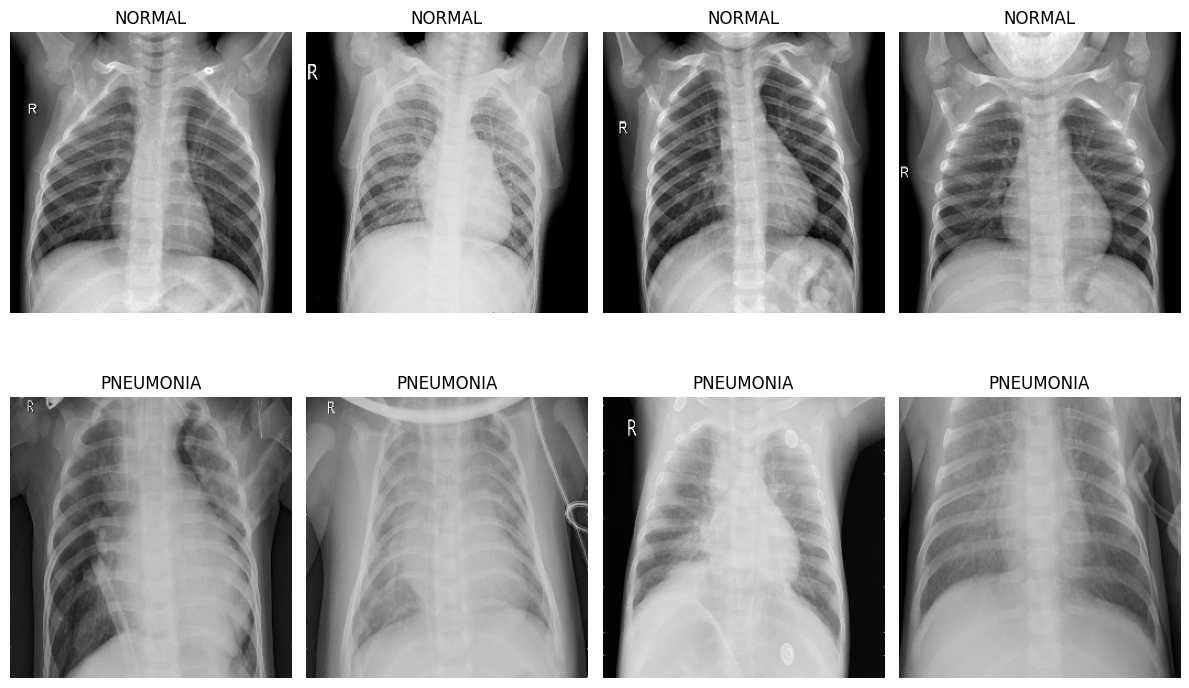


Each image shape is (256, 256, 3)


In [6]:
# Retrieve a selecion of images and labels from train_set
images, labels = next(iter(train_set.take(1)))

# Convert the images and labels to NumPy arrays
images = images.numpy()
labels = labels.numpy()

# Sort the image-label pairs based on the label (ascending order)
sorted_pairs = sorted(zip(images, labels), key=lambda x: x[1])

# Select a sample of images with both normal and pneumonia labels
sample = sorted_pairs[:4] + sorted_pairs[-4:]

# Plot the sorted images with their corresponding labels
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
axes = axes.flatten()

# Format the plot
for i, (image, label) in enumerate(sample):
    axes[i].imshow(image.astype("uint8"))
    axes[i].set_title(train_set.class_names[int(label)])
    axes[i].axis("off")
plt.tight_layout()

# Display the plot
plt.show()
print(f'\nEach image shape is {sample[0][0].shape}')

In [7]:
# Removes no longer needed variables
del images, labels, sorted_pairs, sample

#### INFERENCE

A few things to note:
* The images have 3 channels, despite seeming to be grayscale.
* All X-rays have the right side of the patient (the white 'R' on the image) on the LEFT side of the image. This appears to be consistent across the data set. Given that humans aren't perfectly symmetrical (e.g. our heart is on our left side), we'll not flip any images horizontally. This will preserve the 'sidedness' of the X-rays in case that affects the diagnosis.
* There's a small amount of rotation in the X-rays. Presumably, this is incurred when they take them. We could profit from this by adding rotational augmentation to our training set, which will increase variance without losing 'sidedness'.
* All X--rays picture the same anatomical area. Therefore augmentation tools like `RandomZoom` are unlikely to helpful.
* Brightness and contrast also seem to be stable across the X-rays. Therefore we'll not bother with `RandomBrightness` or `RandomContrast`.

Judging by the similarities between the images, it'll be intriguing to see what results we can get from a simple CNN. What would your guess be?

# Model Building

I'll define a range of helper functions we'll use throughout our modelling.

## Helper Functions

These functions handle the majority of the heavy lifting, allowing me to run and compare models with only a couple lines of code.

As an overview, they are:
* `plot_history` - Plots the training and validation accuracy and loss for each epoch.
* `callback` - I define the early stopping callback in this section. `EarlyStopping` prematurely terminates training if **validation** accuracy doesn't increase within 3 epochs. With this implementation, it then reverts the model weights back to the epoch with the best **validation** accuracy. Settings within this can be tuned. For this project I'm keeping it constant and have chosen patience as 3 to give some allowance for temporary accuracy dips while keeping fast runtimes.
* `fit_plot_store` - This trains the given model, manages model and training history data, and updates or stores model metrics and history in an organized manner.

In [11]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for metric, ax in zip(['accuracy', 'loss'], axs):
      epochs = len(history[metric]) + 1 # Corrects epoch number
      ax.plot(np.arange(1, epochs),
                        history[metric])
      ax.plot(np.arange(1, epochs),
                        history['val_' + metric])
      ax.set_title('Model ' + metric.capitalize())
      ax.set_ylabel(metric.capitalize())
      ax.set_xlabel('Epoch')
      ax.legend(['Train', 'Validation'], loc='upper left')
      ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


# Defines EarlyStopping callback we'll use throughout our modelling
callback = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
patience=3,
verbose=1,
mode='max',
restore_best_weights=True
)

# Initializes the metrics list
model_info = []
model_list = []

def fit_plot_store(model, epochs=10, shuffle=False,
                   batch_size=32, overwrite=False):
    """
    Fit, plot, and store model data, managing existing data when applicable.

    Parameters:
        model (tf.keras.Model): The model to be trained and managed.
        epochs (int, optional): The number of training epochs (default is 10).
        shuffle (bool, optional): Whether to shuffle the training data (default is False).
        batch_size (int, optional): The batch size for training (default is 32).
        overwrite (bool, optional): Whether to overwrite existing model and history data (default is False).

    This function trains the given model, manages model and training history data,
    and updates or stores model metrics and history in an organized manner.

    If `overwrite` is False and existing data for the model is found, it will load the
    existing model and history, preserving previously trained information.

    If `overwrite` is True or no existing data is found, it will train the model from scratch,
    plot the training history, save the model, and store the metrics for reference.

    Returns:
        None
    """
    # Define file name, dirs, and paths
    model_name = model.name
    directories = ['models', 'history']
    model_file = f'models/{model_name}.keras'
    history_file = f'history/{model_name}_history.pkl'

    # Check for existing files
    if (os.path.exists(model_file) and
        os.path.exists(history_file) and
        not overwrite):
        # Load existing model and history
        model = tf.keras.models.load_model(model_file)
        with open(history_file, 'rb') as file:
            history = pickle.load(file)
        print(f'Loaded model and history for {model_name}')
    else:
        # Train the model
        history = model.fit(train_set,
                            epochs=epochs,
                            validation_data=validation_set,
                            shuffle=shuffle,
                            batch_size=batch_size,
                            callbacks=[callback]
                            ).history

        # Makes dirs if needed
        for dir in directories:
          os.makedirs(dir, exist_ok=True)

        # Saves model and history
        model.save(model_file)
        with open(history_file, 'wb') as file:
            pickle.dump(history, file)

    # Plot the history
    plot_history(history)

    # Storing or updating the metrics
    training_accuracy = history['accuracy'][-1]
    val_accuracy = history['val_accuracy'][-1]
    training_loss = history['loss'][-1]
    val_loss = history['val_loss'][-1]
    trainable_params = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    num_epochs = len(history['accuracy'])
    total_params = trainable_params + non_trainable_params

    # Update or store model metrics
    model_info.append([model_name, training_accuracy, val_accuracy,
                       training_loss, val_loss, trainable_params,
                       non_trainable_params, total_params,
                       num_epochs]
                      )

    # Append the model to the model list
    model_list.append(model)


## Initial CNN - Model 1

I'll start with a fairly small model. Below is a quick intro to each layer type.

### The Layers of a CNN

**Rescaling**

  - Ensures all images are on a similar scale by changing pixel values to be between 0 and 1. This standardization helps the model learn more effectively.


**Convolutional Layer (Conv2D)**

  - Acts as a set of filters searching for specific image features, like edges or textures. The "8" represents the number of different filters used, and "3" is the size of the filter, examining small areas of the image for patterns.

**MaxPooling**

  - Simplifies the image by retaining only the most significant features detected by the filters. This is akin to summarizing the prominent features found in the image.

**Flatten**

  - Converts the 2D feature maps into a 1D vector, making it easier to process the data in subsequent layers.

**Dense Layers**

  - Involves fully connected layers that interpret the patterns found by previous layers. The first Dense layer with 8 neurons begins to piece together these patterns to understand the image. The final Dense layer, with a single neuron and sigmoid activation, decides the likelihood of the image being a `NORMAL` or `PNEUMONIA`, outputting a probability between 0 and 1.

In [12]:
model_1 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_1'
    )

model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1048584   
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                           

Our simple model has over a million parameters! Though these are almost all in the dense layers. As we'll see later, more "complicated" models can actually have many less parameters.

Let's see how the model performs.

Loaded model and history for Model_1


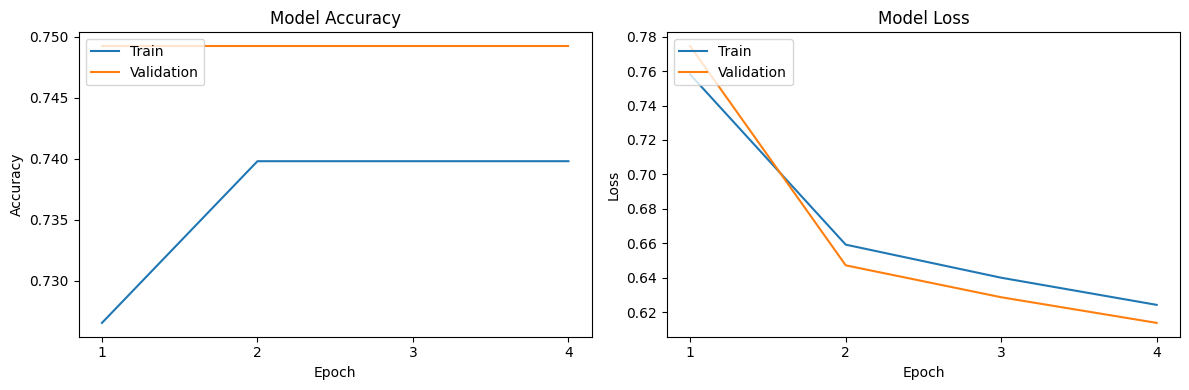

In [13]:
fit_plot_store(model_1)

Our simple model achieved a reasonable 73% accuracy. That's far better than random, yet I wouldn't want to be diagnosed by it yet.

Let's add a few more layers.

## Model 2

We'll add another convolutional layer and a max pooling layer. The `Conv2D` is going to add another set of filters, which will then be further simplified my `MaxPooling2D`. Hence, this model should be far smaller than `model_1`.

In [14]:
model_2 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_2'
    )

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 8)       1160      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0   

We've added two layers and **reduced** the number of parameters by 4X. Given that, how would you now define a complex model?

Let's see how our new model performs.

Loaded model and history for Model_2


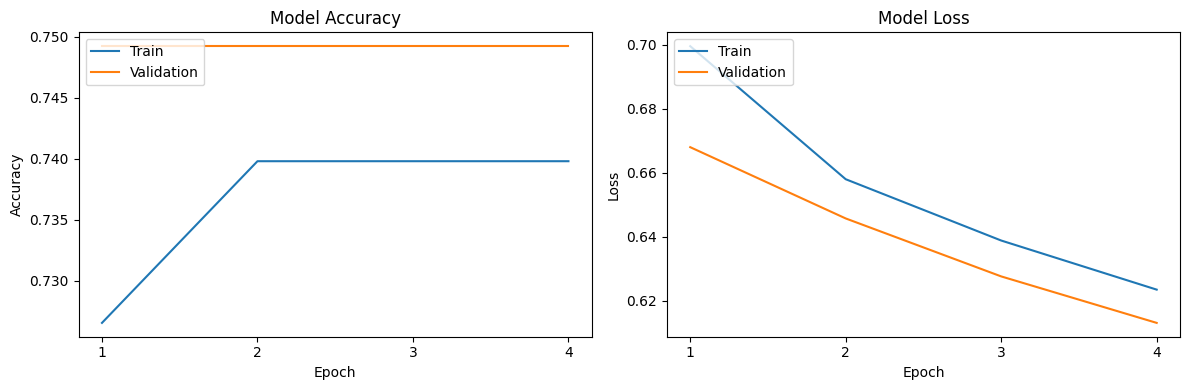

In [15]:
fit_plot_store(model_2)

Our accuracy has improved significantly to around 96% validation accuracy.

The model is beginning to overfit. In fact, the run was terminated early by `EarlyStopping` and didn't complete the default 10 epochs.

### Overfitting
Overfitting is when the model excessively learns from training data, leading to poor performance on new data, often evident by diverging training and validation accuracies during training. This indicates the model's failure to generalize. Techniques such as data augmentation and regularization can help mitigate overfitting.

I'll demonstrate regularization later. For now I'll use augmentation in the next model.



## Model 3

I'm going to try two approaches:
* Rotation - Adding up to 15 degrees of random rotation to some images, which helps by artificially expanding the dataset, making the model less likely to memorize specific image orientations and more robust to variations.
* Shuffle - This shuffles the order of the images, stopping the model from just learning the order, which prevents the model from associating patterns with the sequence rather than the content of the images.

Note, I've not changed the underlying model, just what happens to the images.

In [16]:
model_3 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.RandomRotation(15),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_3'
    )

model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_3.summary()

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 8)       1160      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 8)        0   

Loaded model and history for Model_3


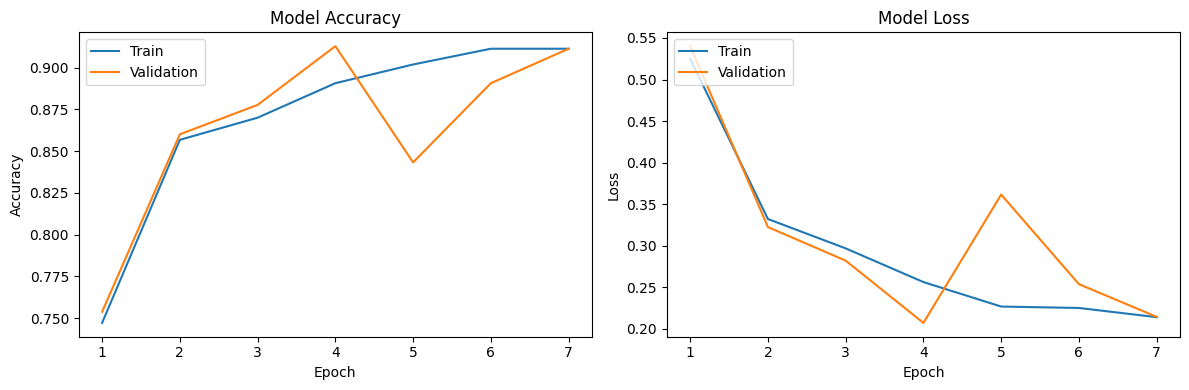

In [17]:
fit_plot_store(model_3, epochs=20, shuffle=True)

Again, `EarlyStopping` has terminated the run early.

Adding shuffle and rotate didn't help. In fact. it reduced the accuracy.

It seems the model wasn't able to cope with the added complexity of augmentation, so lets try a more complex (increasing layers and parameters) model.

In [18]:
model_4 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.RandomRotation(15),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_4'
    )

model_4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_4.summary()

Model: "Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 16)      4624

This 'complicated' model has double the parameters of `model_3` though still approximately half those of `model_1`.

In [19]:
fit_plot_store(model_4, shuffle=True)

Epoch 1/10
123/123 [==============================] - 67s 428ms/step - loss: 0.5151 - accuracy: 0.7319 - val_loss: 0.3860 - val_accuracy: 0.7492
Epoch 2/10
123/123 [==============================] - 49s 395ms/step - loss: 0.4402 - accuracy: 0.7398 - val_loss: 0.4113 - val_accuracy: 0.7492
Epoch 3/10
 97/123 [======================>.......] - ETA: 9s - loss: 0.3792 - accuracy: 0.8035  

KeyboardInterrupt: 

 `EarlyStopping` stopped the run early. This particular run is very angular, and it's possible that it would continue to improve given a few more epochs of patience. However, hyperparameter tuning is outside the scope of this project, so I'll carry on.

`model_4`, arguably the most complicated so far, has produced the second worst result as far as **validation** accuracy. I highlight this because each run, the model trains then checks it's getting better against the validation set. However, validation accuracy is usually different from test accuracy (measured on data never before seen by the model). I'll test all models and compare them at the end. In the meantime, you could begin to rank how you think they'll perform.

As you can see above, the process of tuning a model is long and experimental. We could keep tweaking layers, or even begin tuning hyperparameters. However, in many cases it's faster to finetune an appropriate pretrained model. This is known as **Transfer Learning**.

# Transfer Learning

Transfer learning is a technique that significantly enhances the efficiency and effectiveness of neural networks, including Convolutional Neural Networks (CNNs), by leveraging knowledge gained from previously trained models. Its benefits include:

- **Faster Convergence**: It speeds up the training process by starting from patterns learned on a related task, rather than learning from scratch.
- **Reduced Data Requirement**: It is particularly beneficial when the dataset for the new task is small, as the model can utilize pre-learned features, reducing the need for extensive data.
- **Improved Performance**: Models often achieve higher accuracy and generalization on new tasks by building upon the foundations of previously learned features and patterns.
- **Efficiency and Adaptability**: Transfer learning allows for more efficient use of computational resources and makes it easier to adapt models to new, but related, problems, showcasing versatility across various applications.

Overall, transfer learning streamlines the development of more robust, accurate, and efficient neural networks by making the most of pre-existing knowledge and data. So lets put that into practice. I'm going to use a variant of ResNet, a model that was trained on the [ImageNet](https://www.image-net.org/) dataset.

### ImageNet
ImageNet is a large-scale visual database designed for use in visual object recognition software research, containing over 14 million images categorized into thousands of classes. It has been instrumental in advancing computer vision and deep learning by providing a vast dataset for training and benchmarking algorithms.

### ResNet (Residual Network)
 ResNet is a type of convolutional neural network (CNN) architecture that introduced the concept of residual learning to facilitate the training of much deeper networks. By using shortcut connections that skip one or more layers, ResNet models can efficiently learn identity mappings, allowing for the successful training of networks with hundreds or even thousands of layers. This innovation significantly improved performance on challenging computer vision tasks, setting new benchmarks for image classification accuracy.

## ResNet50

This is the smallest, therefore fastest and least computationally intensive, of the pretrained ResNet models available directly through Keras. The model was pretrained to classify 1000 classes, none of which where pneumonia on chest X-rays. Therefore, it'll benefit from some additional learning to transfer to this context.

## First ResNet50 Model
I have to add and train a single dense layer at the end. This is because we want to update it for binary classification instead of it's original use. I'll freeze the entire ResNet50 model and just update our single node dense layer. This is as close as we can get to applying the model 'out of the box'.

In [20]:
# Build a ResNes 50 model
resnet50_base = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='max',
    input_shape=(img_size[0], img_size[1], 3)
)

# Freeze the ResNet50 model
resnet50_base.trainable = False

# Add a dense layer
resnet50 = models.Sequential([
    resnet50_base,
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50'
    )


# Compile the model
resnet50.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_12 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


Note that for our 23.5 million parameter model, we're only training 2,049 parameters. Again, does that make it more, or less complex? Especially considering how few lines of code it took to implement.

Before we fit our model, I need to preprocess the image. ResNet50 has strict expectations of the images. As the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input) explains:
> The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

I'm not actually changing the image, per se, just adjusting the ranges and order of the pixels. It still contains the same underlying information. As such, we can still directly compare the ResNet results against the hand-coded models.


Loaded model and history for ResNet50


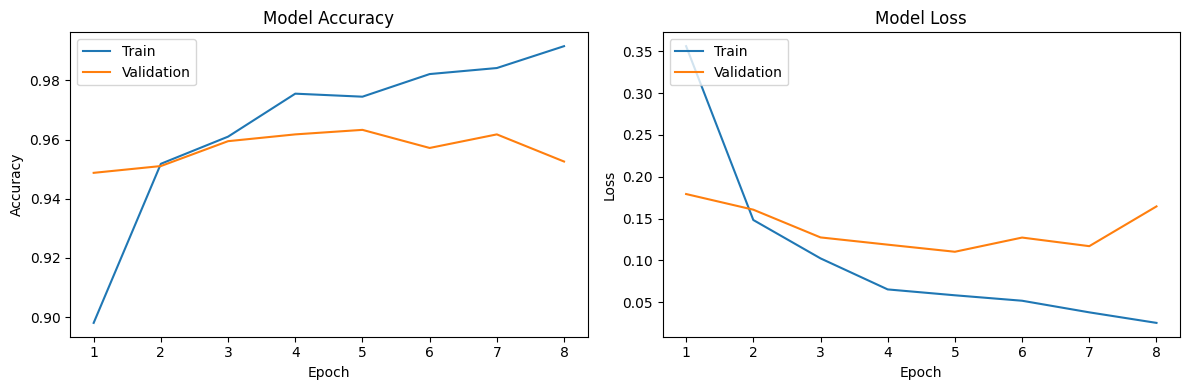

In [21]:
# Define the preprocessing function
def preprocess_image(image, label):
    image = applications.resnet.preprocess_input(image)
    return image, label

# Apply necessary preprocessing using tf.data.Dataset.map()
resnet_train = train_set.map(preprocess_image)
resnet_val = validation_set.map(preprocess_image)
resnet_test = test_set.map(preprocess_image)

# Train the model
fit_plot_store(resnet50)

Our accuracy is high at ~96%-98% for the validation set. We're also showing clear signs of overfitting.

## Second ResNet50 Model

I'm going to turn shuffle back on to stop the model learning image sequence. I'm also going to add dropout.

### Dropout
[Dropout](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) is a regularization technique used in neural networks to prevent overfitting by randomly "dropping out" a proportion of neurons in the network during training. This forces the network to learn more robust features that are useful across different subsets of the data, as it cannot rely on the presence of any single neuron. For this project, I'm using a fixed dropout rate of 0.3, in the middle of the [recommended](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#add_dropout) 0.2-0.5 range.

In [22]:
# Add a dense layer and dropout
resnet50_2 = models.Sequential([
    resnet50_base,
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50_2'
    )

# Compile the model
resnet50_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50_2.summary()

Model: "ResNet50_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_13 (Dense)            (None, 8)                 16392     
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 23,604,113
Trainable params: 16,401
Non-trainable params: 23,587,712
_________________________________________________________________


Loaded model and history for ResNet50_2


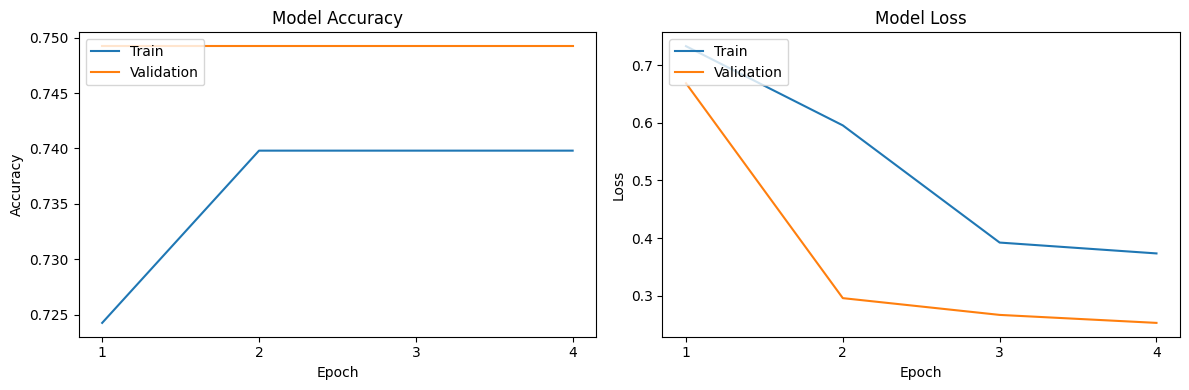

In [23]:
fit_plot_store(resnet50_2, shuffle=True)

For the first time, our validation accuracy is better than our training accuracy. That's not in error, it's because during the training phase, we're randomly losing 30% of our neurons via dropout. However, they're all used during the validation phase, improving the performance.

Still, the model is definitely overfitting! `EarlyStopping` caught this and stopped the training. The model's been reverted back to it's best epoch, which had ~96% accuracy. Based solely on validation accuracy, that means there's been no improvement in the model. Do you think that will hold with test accuracy?

## Third ResNet50 Model

Since our last model was overfitting, I'm going to add one more thing to counter that. This time, I'll also use [regularizers](https://towardsdatascience.com/ridge-lasso-and-elasticnet-regression-b1f9c00ea3a3) (confusingly, another type of regularization).

### L1 Regularization (Lasso Regression)
[L1 regularization](https://en.wikipedia.org/wiki/Lasso_(statistics) adds a penalty equal to the absolute value of the magnitude of coefficients, encouraging sparsity by driving some coefficients to zero. This can be particularly useful for feature selection in models with high-dimensional data.

### L2 Regularization (Ridge Regression)
[L2 regularization](https://en.wikipedia.org/wiki/Ridge_regression) adds a penalty equal to the square of the magnitude of coefficients, effectively penalizing large coefficients but without making them exactly zero. It helps in controlling overfitting by ensuring the model coefficients do not grow too large, making the model more robust.

### Elastic Net Regularization
[Elastic Net](https://en.wikipedia.org/wiki/Elastic_net_regularization) combines L1 and L2 regularization, adding both penalties to the loss function, thus leveraging the benefits of both methods: feature selection from L1 and smooth shrinkage from L2. It's especially useful when dealing with highly correlated data, as it balances the variance reduction of L2 with the feature selection properties of L1.


In [24]:
# Adding a dense layer, more dropout and regularization
resnet50_3 = models.Sequential([
    resnet50_base,
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50_3'
    )

# Compile the model
resnet50_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50_3.summary()

Model: "ResNet50_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_15 (Dense)            (None, 8)                 16392     
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
Total params: 23,604,113
Trainable params: 16,401
Non-trainable params: 23,587,712
_________________________________________________________________


Loaded model and history for ResNet50_3


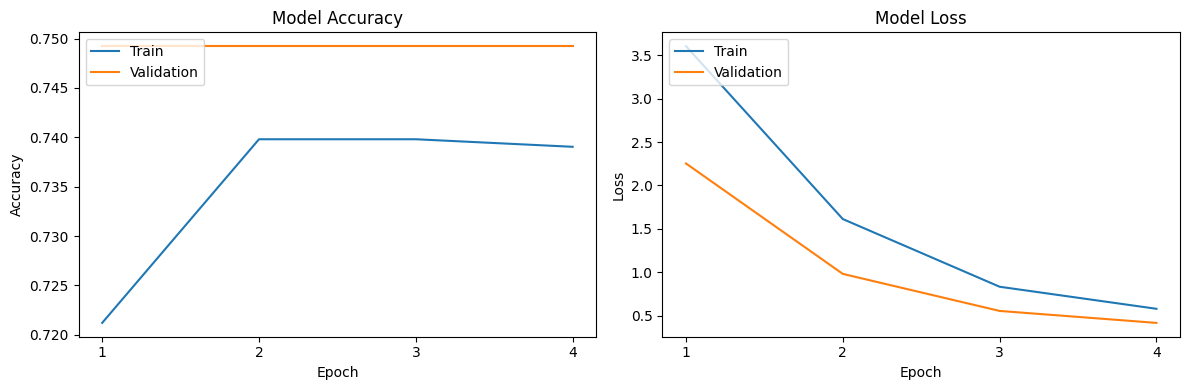

In [25]:
fit_plot_store(resnet50_3, shuffle=True)

Does that look good to you? It has the lowest accuracy of the `ResNet50` models, though it's not necessarily showing the same signs of overfitting. Perhaps it would benefit from a higher patience `EarlyStopping` callback. Or perhaps we have over-regularized the model.

Either way, I now have a variety of models. Lets stack them up against each other.

# Comparing Models

If you've been counting, you'll realise that I've created and run 7 models. I can't easily compare that many in my head, so below I'll compare the key features.

First, let's pull all their information into a DataFrame.

In [28]:
column_names = ['Model Name', 'Training Accuracy', 'Validation Accuracy',
                'Training Loss', 'Validation Loss', 'Trainable Parameters',
                'Non-trainable Parameters', 'Total Parameters',
                'Number of Epochs']


# Changes the list to a DataFrame
model_info_df = pd.DataFrame(model_info, columns=column_names)
model_info_df.set_index('Model Name', inplace=True)

# Sort the DataFrame by Model Name
model_info_df.sort_values('Model Name', inplace=True)
model_info_df

,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss,Trainable Parameters,Non-trainable Parameters,Total Parameters,Number of Epochs
Model Name,,,,,,,,
Model_1,0.739806,0.749235,0.624260,0.613794,1048817,0.0,1048817.0,4
Model_2,0.739806,0.749235,0.623509,0.613116,263769,0.0,263769.0,4
Model_3,0.911315,0.911315,0.213984,0.214351,263769,0.0,263769.0,7
ResNet50,0.991590,0.952599,0.025220,0.164473,2049,23587712.0,23589761.0,8
ResNet50_2,0.739806,0.749235,0.373266,0.252700,16401,23587712.0,23604113.0,4
ResNet50_3,0.739042,0.749235,0.581574,0.419529,16401,23587712.0,23604113.0,4


Complexity, again, is an interesting thing to compare across models. Especially looking at the difference between trainable and total parameters. The smallest ResNet50 model has ~130X fewer trainable parameters than the smallest 'vanilla' CNN. Yet `ResNet50` is ~90X bigger by total parameters.

Generally, a good measure is layer complexity, followed by total parameters. The reason ResNet seems simple is that all the layers are hidden behind a simple call to TensorFlow. In reality, there is a lot of hidden architecture, and it's this that drives the models capabilities.

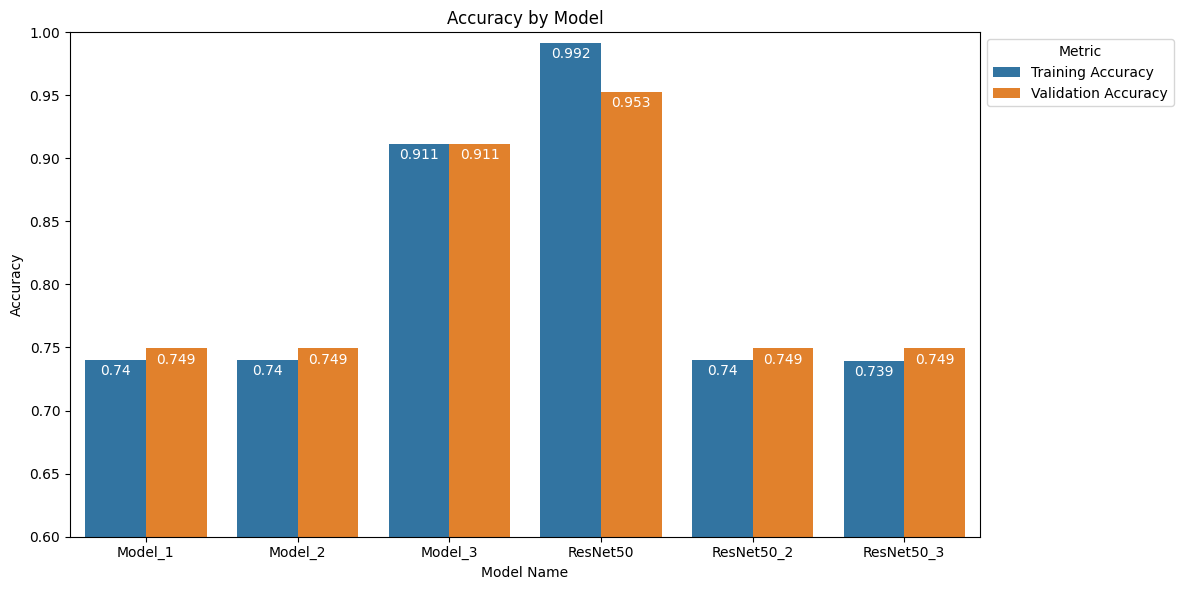

In [29]:
def plot_accuracy(df, vars, subtitle=''):
    '''Plots the specified accuracies (vars) for each model in df'''
    # Reshape the data from wide to long format
    melted_df = df.reset_index().melt(id_vars='Model Name',
                                      value_vars=vars,
                                      var_name='Metric',
                                      value_name='Accuracy')

    # Plot the vertical bar chart using Seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Model Name', y='Accuracy',
                     hue='Metric', data=melted_df, errorbar=None)


    # Set the title and axis labels
    plt.title('Accuracy by Model' + subtitle)
    plt.xlabel('Model Name')
    plt.ylabel('Accuracy')
    plt.ylim(0.6, 1)
    plt.tight_layout()

    # Add value labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3g', label_type='edge',
                     padding=-13, color='white'
                     )

    # Move the legend to the right of the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Metric')


    # Display the plot
    plt.show()

# Usage
plot_accuracy(model_info_df,
              ['Training Accuracy', 'Validation Accuracy']
              )

That's showing accuracy in model order. Note how accuracy is going down as the models get more complicated. That doesn't mean they'll necessarily perform worse. In this case, it likely means they're less overfitted and will perform better on new, unseen data.

Really, I'd  interested in the most accurate models if I was to actually use this to detect pneumonia. One way to judge this would be to sort by validation accuracy.

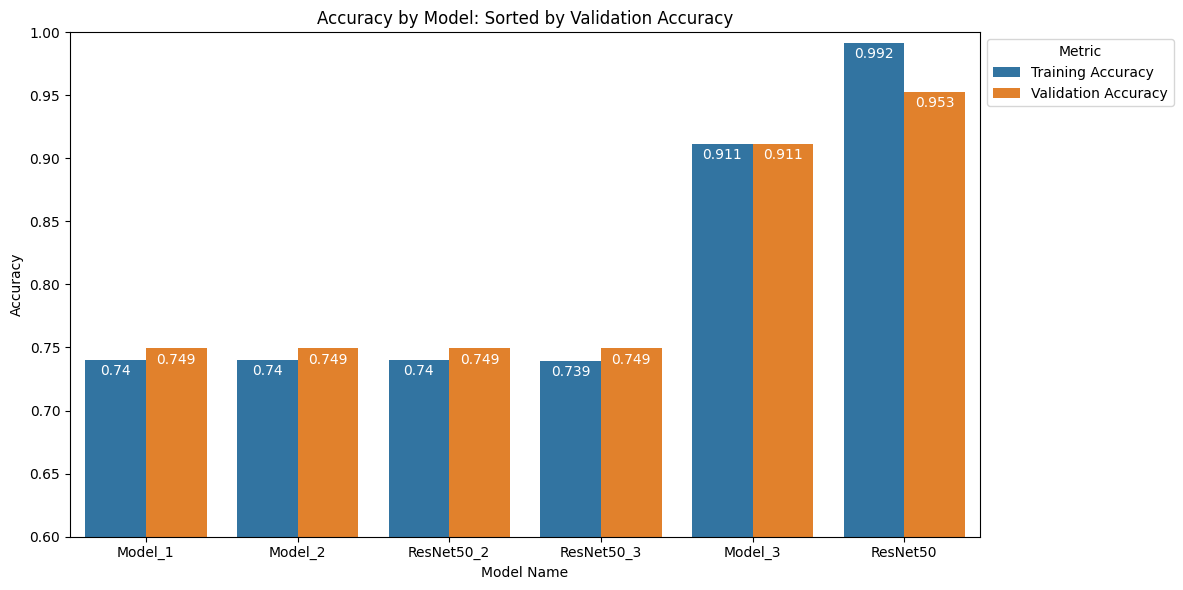

In [30]:
# Sort the DataFrame by test accuracy
by_val = model_info_df.sort_values('Validation Accuracy')
plot_accuracy(by_val,
              ['Training Accuracy', 'Validation Accuracy'],
              subtitle=': Sorted by Validation Accuracy'
              )

The ResNet models are generally outperforming my hand created ones. That's not surprising given how much more complex ResNet50 is. Though interestingly, `model_2` has made it to third place.

Finally, it's time to see how they fare on unseen data.

# Assessing Real World Performance

There are seven models, all with different architectures. Above, you can see how they perform on the validation set. But, as mentioned before, that's only so indicative of how they'll perform on the test set. Some will have overfitted and not be able to generalize to unseen data.

So the key question is, given what you've seen so far, which model would you choose to be diagnosed by?




# Got to here

In [31]:
test_accuracy = []
test_loss = []

for model in model_list:
    # Evaluate the model on the test set
    print(model.name)
    loss, accuracy = model.evaluate(test_set)
    test_accuracy.append(accuracy)
    test_loss.append(loss)

model_info_df['Test Accuracy'] = test_accuracy
model_info_df['Test Loss'] = test_loss

Model_1
20/20 [==============================] - 2s 44ms/step - loss: 1.1883 - accuracy: 0.6250
Model_2
20/20 [==============================] - 2s 39ms/step - loss: 0.6813 - accuracy: 0.6250
Model_3
20/20 [==============================] - 1s 34ms/step - loss: 0.3978 - accuracy: 0.8189
ResNet50
20/20 [==============================] - 5s 165ms/step - loss: 0.7436 - accuracy: 0.8237
ResNet50_2
20/20 [==============================] - 4s 159ms/step - loss: 0.6815 - accuracy: 0.6250
ResNet50_3
20/20 [==============================] - 5s 160ms/step - loss: 2.4035 - accuracy: 0.6250


Did you choose correctly? Which model result most surprised you?

Let's dig into these results. Rather than comparing numbers directly, I'll graph **test accuracy** so we can compare visually. I'll also include **training accuracy** and **validation accuracy** so we can see how they relate to **test accuracy**.

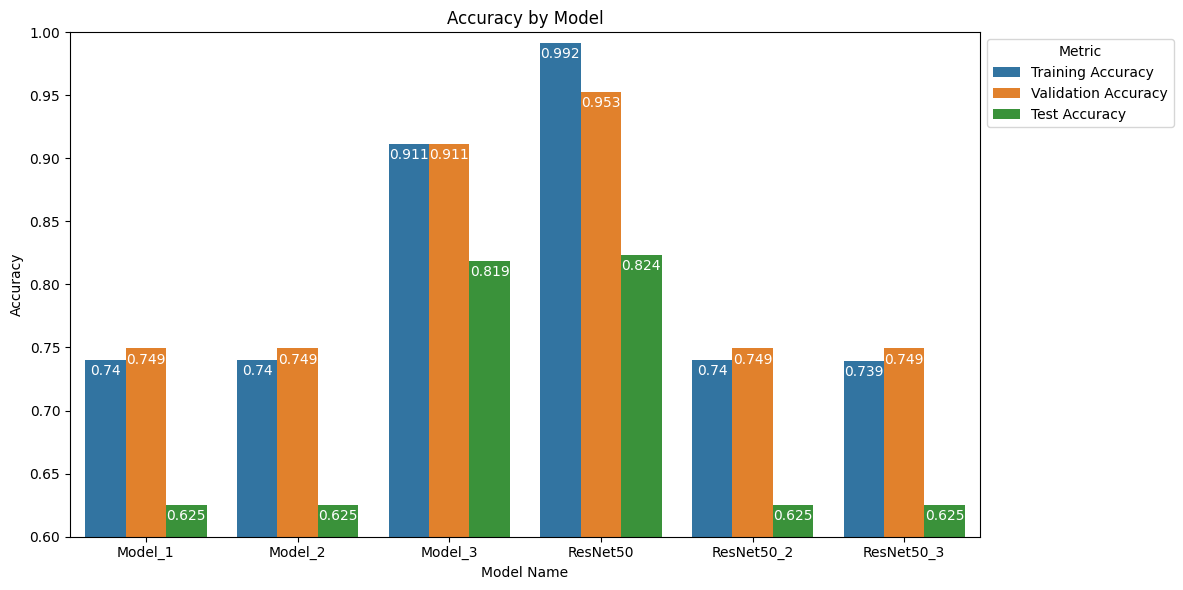

In [32]:
# Usage
plot_accuracy(model_info_df,
              ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy']
              )

One reassuring thing to note is that performance generally got better. Our first model has the lowest accuracy, and through increasing complexity and reducing overfitting, each model (generally) performed better than the last.

`ResNet50` is the only model to break this pattern, though that was created by adding one node onto a frozen non-domain specific, pre-trained model. Even still, it beat 3 out of 4 hand-coded models, highlighting the power of **Transfer Learning**. Competitive results can be achieved with only a single trained node.

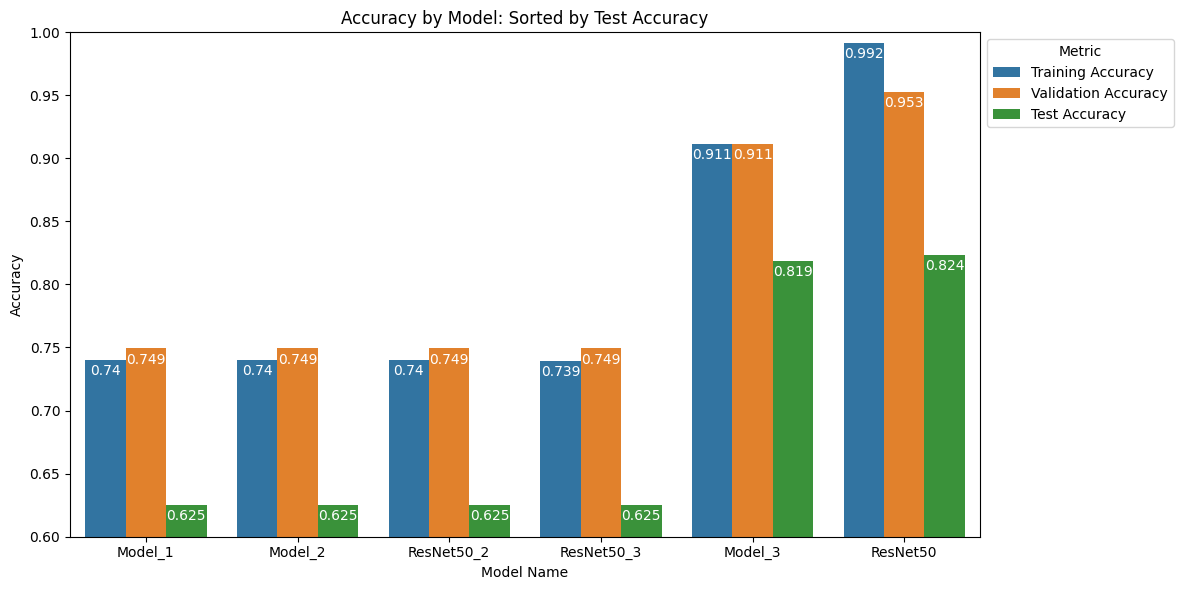

In [33]:
# Sort the DataFrame by test accuracy
by_val = model_info_df.sort_values('Test Accuracy')
plot_accuracy(by_val,
              ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy'],
              subtitle=': Sorted by Test Accuracy'
              )

Sorted by **test accuracy**, it's clear that the more complicated models  performed better. Though this generally comes with higher computation requirements. Using **Transfer Learning** mitigated much of this, though (with current hyperparameters) the ResNet models still used around 8GB of GPU RAM, which is far from trivial.

In [ ]:
# # Uncomment if needed
# from google.colab import files
# directories = ['models', 'history']
# for dir in directories:
#     !zip -r /content/{dir}.zip /content/{dir}
#     files.download(f'{dir}.zip')